In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue, Queue
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
from plotting import plot_linestring, plot_polygon
from heuristics import euclidean_distance
from planning_utils import a_star, heuristic, create_grid
from udacidrone.frame_utils import global_to_local, local_to_global
from skimage.morphology import medial_axis
from skimage.util import invert

In [4]:
from planning_engines import get_main_plan, get_global_home, get_medial_axis_path, get_local_box_and_local_target, a_star_3d, create_voxmap, Local3DPlanner

In [5]:
filename='colliders.csv'
global_home = get_global_home(filename)
global_position=np.array([-122.3943410,37.7915164, 0])
current_local_pos = global_to_local(global_position, global_home)
#current_local_pos = (0, 0)

#goal_lon, goal_lat = -122.39441123, 37.79141968 # main str between mission and howard
#goal_lon, goal_lat = -122.398721, 37.7931154  # front street (a block from McDonalds)
#goal_lon, goal_lat = -122.402402, 37.795429  # top left, issue getting there with voxel map. good example for replanning
goal_lat, goal_lon = 37.796368, -122.396908 # between the trees on the north side
#goal_lat, goal_lon = 37.793245, -122.397746
#goal_lat, goal_lon = 37.793212, -122.401092 # middle left, nice long path with some narrow passages

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 3

In [6]:
global_path, data, north_offset, east_offset = get_main_plan(global_home, goal_lat, goal_lon, current_local_pos)

North offset = 316, east offset = 445
Local Goal: {0}
Local Start and Goal:  (210, 719) (747, 489)
Found a path.
number of waypoints: 609
number of waypoints after pruning: 237
number of waypoints after collinearity pruning: 237
number of waypoints after raytracing pruning: 14


In [7]:
grid, nmin, emin = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

In [8]:
# reverse to grid coordinates
grid_path = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in global_path]

In [9]:
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

North offset = 316, east offset = 445


In [10]:
grid_start = (int(current_local_pos[0] + north_offset), int(current_local_pos[1] + east_offset))
local_goal = global_to_local((goal_lon, goal_lat, 0), global_home)
grid_goal = (int(local_goal[0] + north_offset), int(local_goal[1] + east_offset))
print('Local Start and Goal: ', grid_start, grid_goal)

Local Start and Goal:  (210, 719) (747, 489)


In [11]:
_, skeleton = get_medial_axis_path(grid, grid_goal, grid_start)

Found a path.


In [12]:
E, N= 1, 0

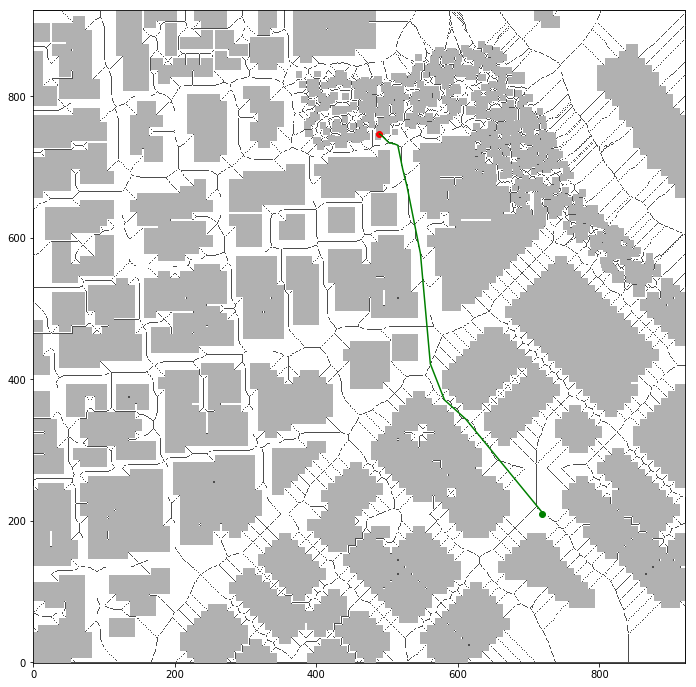

In [13]:
fig, ax = plt.subplots(1,1)
#ax.imshow(grid==0, cmap='gray')
ax.imshow(grid, origin='lower', cmap='Greys') 
ax.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

_ = ax.plot(grid_start[E], grid_start[N], 'go')
#_ = ax.plot(skel_start[E], skel_start[N], 'gx')
#_ = ax.plot(skel_goal[E], skel_goal[N], 'rx')
_ = ax.plot(grid_goal[E], grid_goal[N], 'ro')
pp = np.array(grid_path)
_ = ax.plot(pp[:,E], pp[:,N], '-', c='green')

In [14]:
global_path

[[-105, 275, 5, 0],
 [28, 166, 5, 0],
 [55, 136, 5, 0],
 [106, 116, 5, 0],
 [262, 102, 5, 0],
 [357, 83, 5, 0],
 [381, 77, 5, 0],
 [415, 70, 5, 0],
 [417, 65, 5, 0],
 [417, 63, 5, 0],
 [418, 62, 5, 0],
 [418, 58, 5, 0],
 [429, 47, 5, 0],
 [431, 44, 5, 0]]

In [15]:
from matplotlib import collections as mc

def plot_local_path(local_planner, grid, grid_path, ax=None, local_path=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(7, 7))    
    E, N = 1, 0
    _ = ax.plot(local_planner.grid_position[E], local_planner.grid_position[N], 'ro', label="current position")
    _ = ax.plot(local_planner.grid_next_waypoint[E], local_planner.grid_next_waypoint[N], 'x', c="orange", label="next global waypoint")

    if local_path is None:
        lines = [((local_planner.grid_position[E], local_planner.grid_position[N]),
                  (local_planner.grid_next_waypoint[E], local_planner.grid_next_waypoint[N]))]
        lc = mc.LineCollection(lines, colors="green", linewidths=2)
        ax.add_collection(lc)

    for p1, p2 in local_planner.grid_local_box:    
        ax.plot([p1[E], p2[E]], [p1[N], p2[N]], alpha=0.7, c="blue", linewidth=1, solid_capstyle='round', zorder=2, label="local view")
        #ax.plot([p1[E], p2[E]], [p1[N], p2[N]], 'o', zorder=1)

    ax.plot(local_planner.grid_local_goal[E], local_planner.grid_local_goal[N], 'rx', label="local goal")  
    
    xlim = (min([local_planner.ymin, local_planner.grid_position[E], local_planner.grid_next_waypoint[E]]) - 10,
            max([local_planner.ymax, local_planner.grid_position[E], local_planner.grid_next_waypoint[E]]) + 10)
    ylim = (min([local_planner.xmin, local_planner.grid_position[N], local_planner.grid_next_waypoint[N]]) - 10,
            max([local_planner.xmax, local_planner.grid_position[N], local_planner.grid_next_waypoint[N]]) + 10)  
        
    ax.imshow(grid, origin='lower', cmap='Greys') 
    pp = np.array(grid_path)
    ax.plot(pp[:,E], pp[:,N], '--', c="orange", label="global path")
    
    if local_path is not None:
        local_pp = np.array(local_path)
        ax.plot(local_pp[:,E], local_pp[:,N], '-', c="red", label="local path")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.set_title("Local Planning 2D View")
    ax.set_xlabel("East")
    ax.set_ylabel("North")
    ax.legend(loc="best")

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def plot_local_path_3d(local_planner, local_path=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    current_view = local_planner.current_view
    ax.voxels(current_view, edgecolor='k')
    ax.set_xlim(current_view.shape[0], 0)
    ax.set_ylim(0, current_view.shape[1])
    ax.set_zlim(0, current_view.shape[2] )

    #trajectory = np.array([local_planner.grid_voxel_current_position, local_planner.grid_voxel_local_goal])
    #ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2])
    if local_path is not None:
        v = ax.voxels(local_planner.path_voxels(local_path), facecolors="red", edgecolor='k', label="path")
    _ = ax.set_xlabel('North')
    _ = ax.set_ylabel('East')
    #_ = ax.set_title("Local Planning 3D View")


In [17]:
def plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=None, local_voxel_path=None, figsize=(14,7), filename=None):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d') 
    plot_local_path(local_planner, grid, grid_path, ax=ax1, local_path=local_waypoints)
    plot_local_path_3d(local_planner, ax=ax2, local_path=local_voxel_path)
    if filename is not None:
        plt.savefig(filename)


In [59]:
i = 0
j = 0
global_path_stack = Queue()
[global_path_stack.put(p) for p in global_path]

current_position = current_local_pos
#next_waypoint = global_path_stack.get()
voxel_size = 2
max_altitude = 10

local_planner = Local3DPlanner(global_path_stack, data, north_offset, east_offset, voxel_size, TARGET_ALTITUDE, max_altitude)

In [60]:
local_planner.update_position(current_position)
local_path, local_voxel_path = local_planner.plan()
grid_local_path = [tuple(np.array(p) + np.array([north_offset, east_offset, 0, 0]))  for p in local_path]

waypoint inside current view, moving on to next waypoint [ 28 166   5]
Found a path.


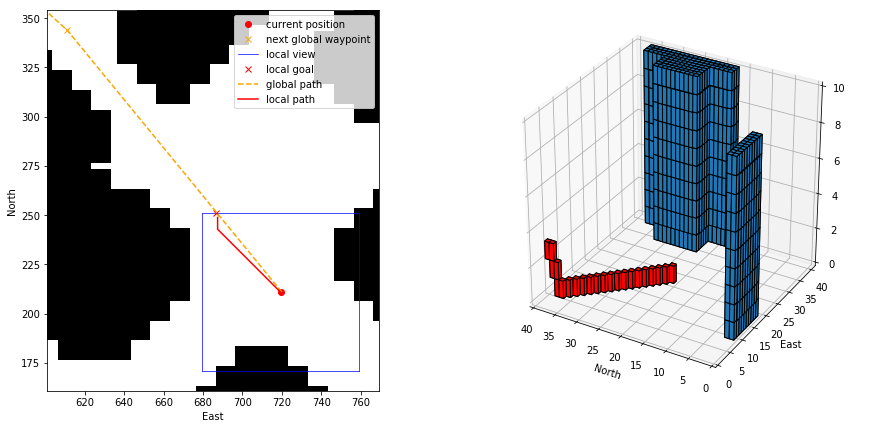

In [61]:
plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=grid_local_path, local_voxel_path=local_voxel_path, figsize=(15,7))

In [62]:
current_position = local_path[-1][:3]
local_planner.update_position(local_path[-1][:3])

In [63]:
local_path, local_voxel_path = local_planner.plan()

Found a path.


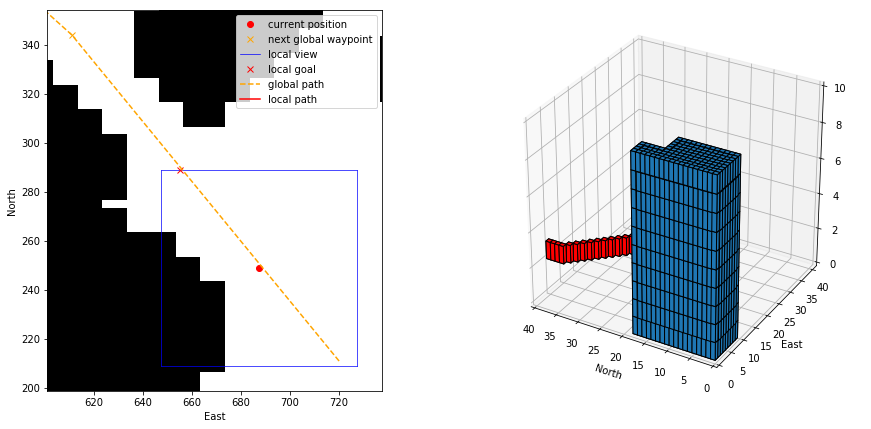

In [64]:
plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=local_path, local_voxel_path=local_voxel_path, figsize=(15,7))

In [303]:
local_path[-1]

(79.85756243485957, -321.57431856379844, 5.0, 0.0)

In [299]:
local_planner.waypoint_queue.empty()

True

# End to End Local Planning

comment out `plot_local_planning_2d_and_3d` to generate plots for each local planning step. 
png files are written to the local_planning folder

Found a path.
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [ 55 136   5]
Found a path.
waypoint inside current view, moving on to next waypoint [106 116   5]
Found a path.
waypoint inside current view, moving on to next waypoint [262 102   5]
Found a path.
Found a path.
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [357  83   5]
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [381  77   5]
Found a path.
waypoint inside current view, moving on to next waypoint [415  70   5]
Found a path.
waypoint inside current view, moving on to next waypoint [417  65   5]
waypoint inside current view, moving on to next waypoint [417  63   5]
waypoint inside current view, moving on to next waypoint [418  62   5]
waypoint inside current view, moving on to next waypoint [418  58   5]
waypoint inside current view, moving on to next waypoint [429  47   5]
waypoint inside current view, moving 

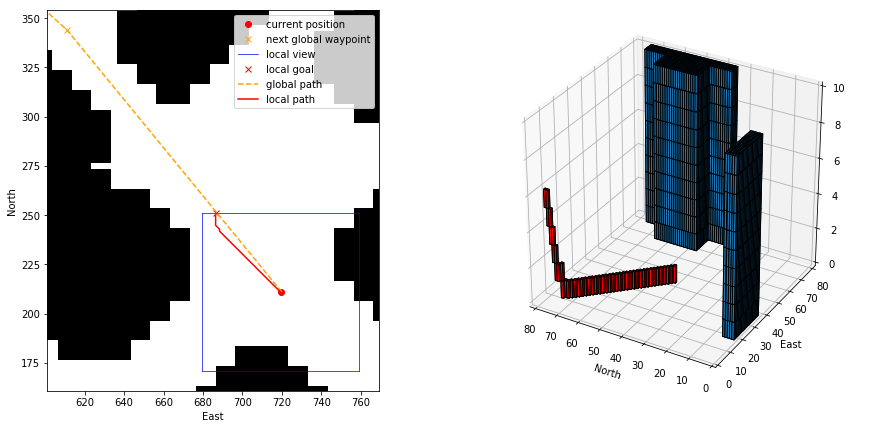

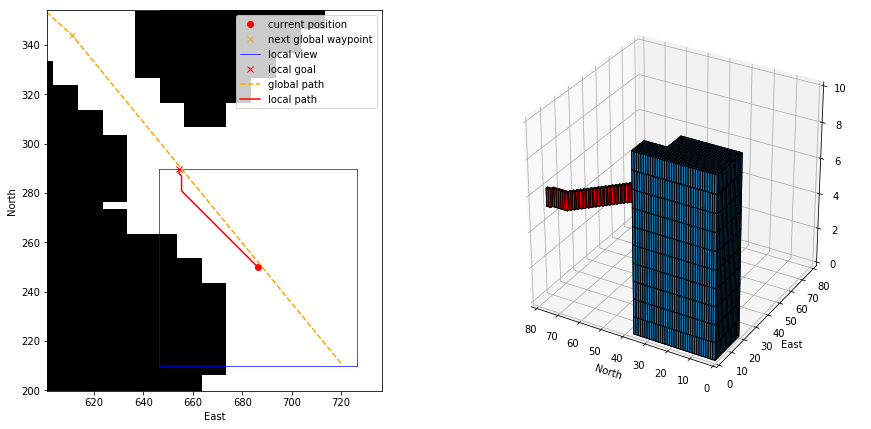

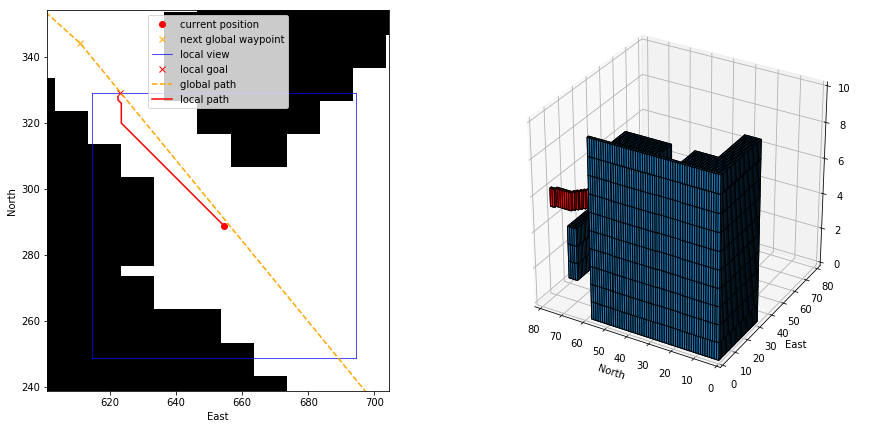

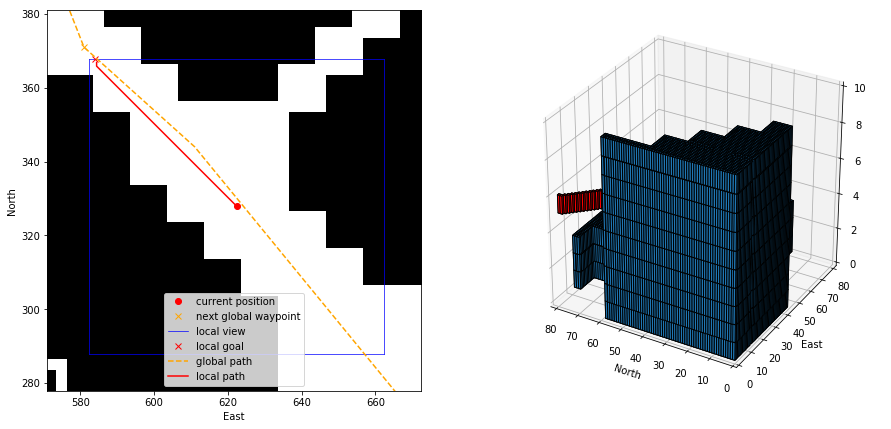

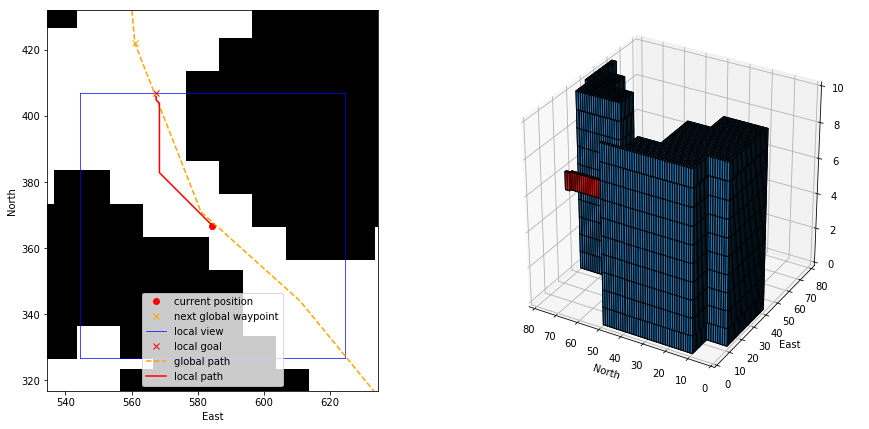

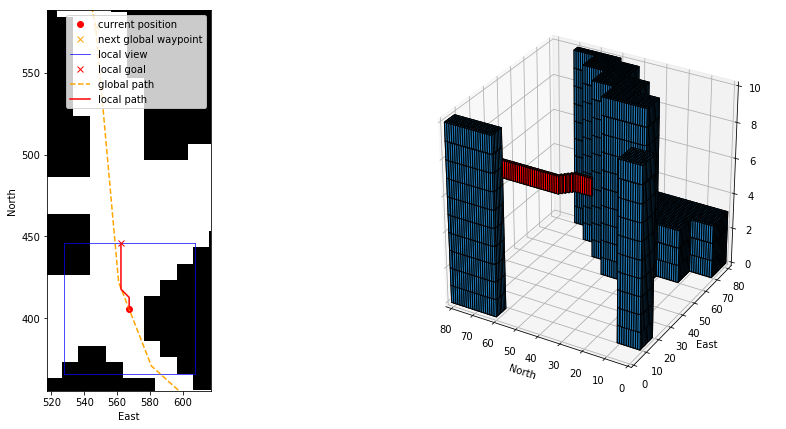

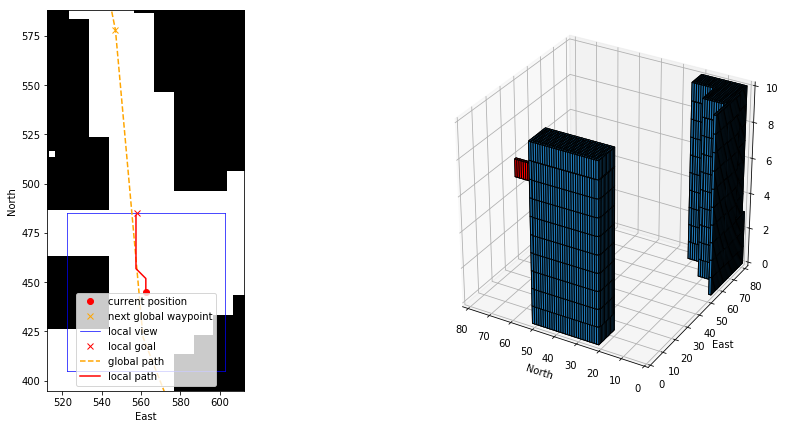

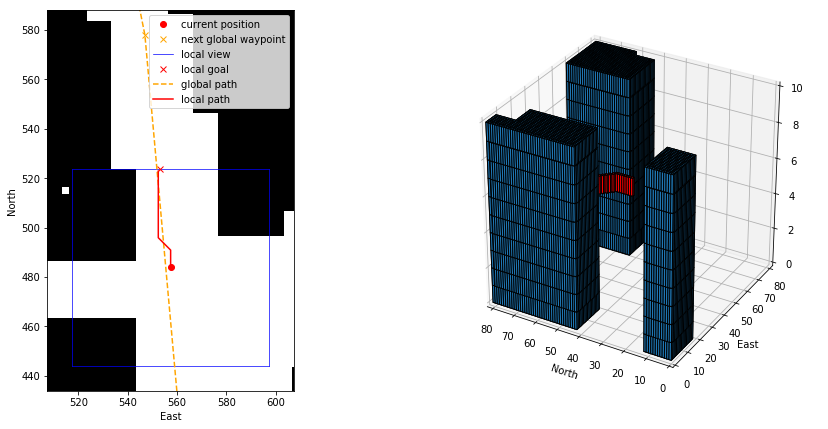

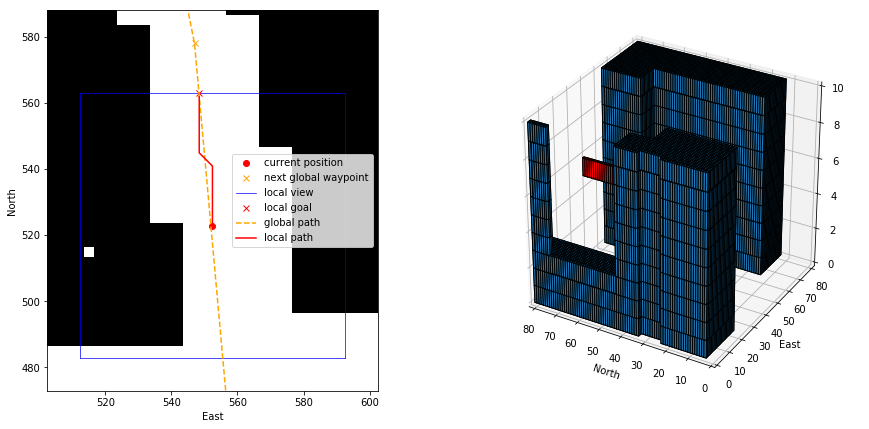

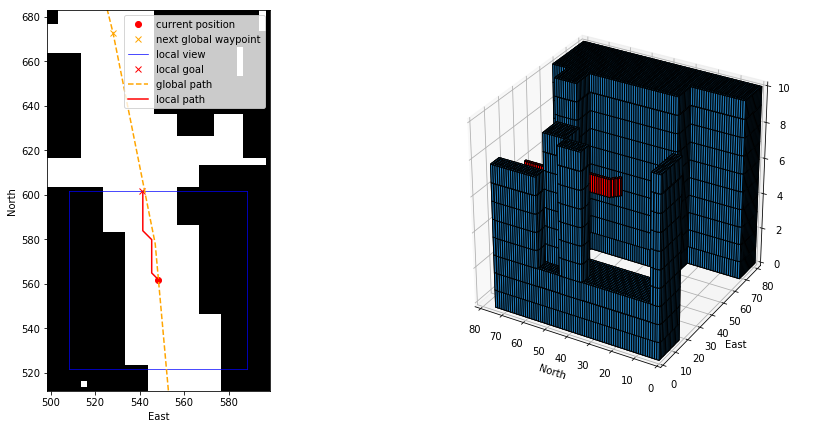

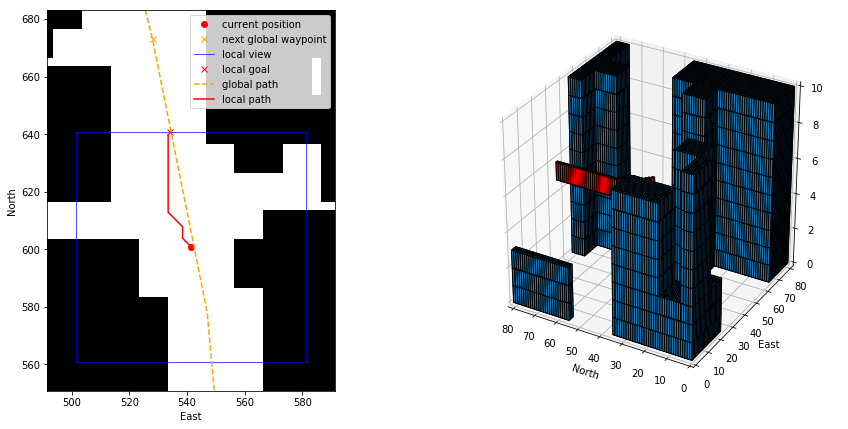

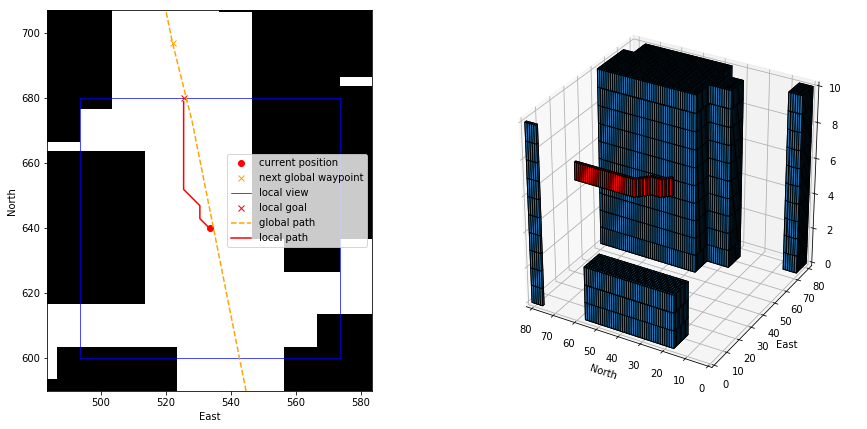

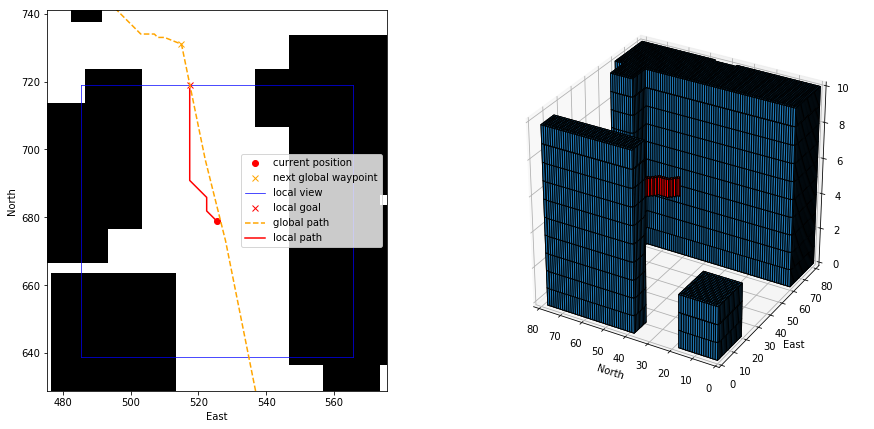

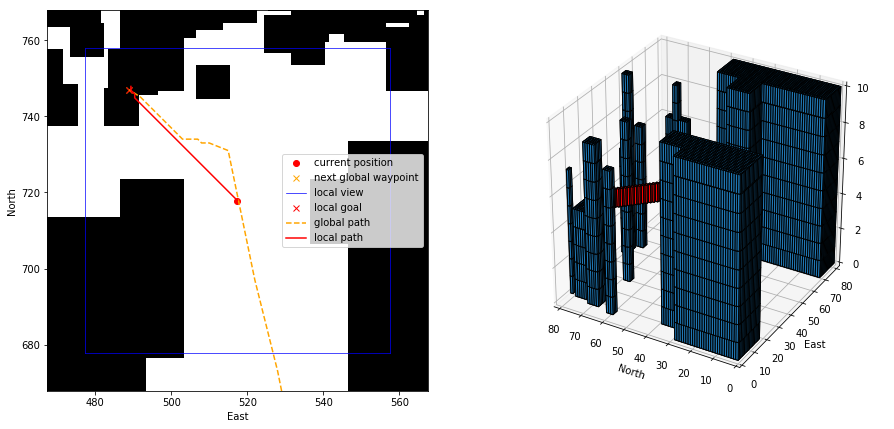

In [18]:
import queue
i = 0
global_path_stack = queue.Queue()
[global_path_stack.put(p) for p in global_path]
current_position = current_local_pos
next_waypoint = global_path_stack.get()
voxel_size = 1
max_altitude = 10
local_planner = Local3DPlanner(global_path_stack, data, north_offset, east_offset, voxel_size, TARGET_ALTITUDE, max_altitude)

while not local_planner.waypoint_queue.empty():    
    local_planner.update_position(current_position)
    local_path, local_voxel_path = local_planner.plan()
    grid_local_path = [tuple(np.array(p) + np.array([north_offset, east_offset, 0, 0]))  for p in local_path]
    plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=grid_local_path, local_voxel_path=local_voxel_path, figsize=(15,7), filename="local_planning/local_planning_%d.png"%(i))    
    # set current position to last point of local path
    current_position = local_path[-1][:3]
    i+=1

# Validation

In [42]:
view = np.zeros(local_planner.current_view.shape, dtype=bool)

# wall along the east-west direction, with one opening
view[8, :, :] = True
view[8, :15, 4:] = False
view[8, :, 9:] = False

start = np.array([35, 5, 1])
goal = np.array([0, 20, 1])
path, _ = a_star_3d(view, euclidean_distance, start, goal)
path_voxels = np.zeros(view.shape, dtype=bool)
for x,y,z in path:
    path_voxels[x,y,z] = True

Found a path.


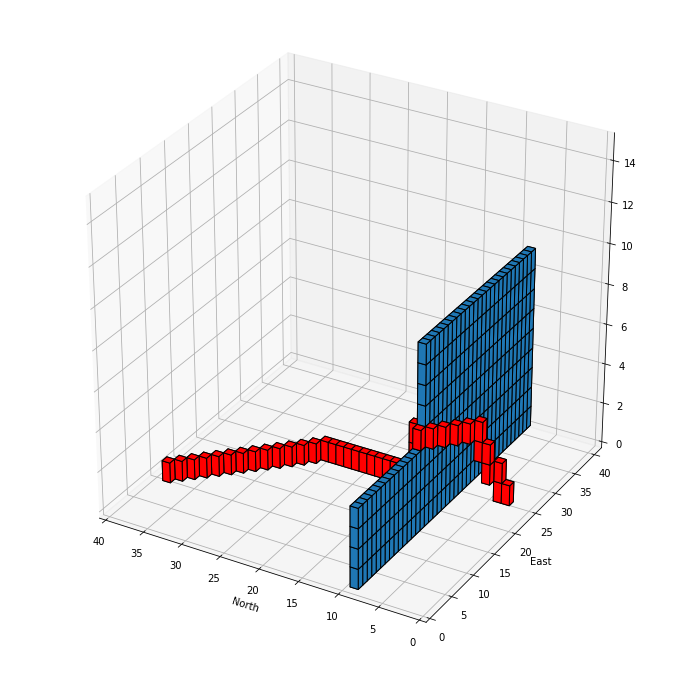

In [44]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(view, edgecolor='k')
ax.set_xlim(view.shape[0], 0)
ax.set_ylim(0, view.shape[1])
ax.set_zlim(0, view.shape[2] + 5)

v = ax.voxels(path_voxels, facecolors="red", edgecolor='k', label="path")
_ = ax.set_xlabel('North')
_ = ax.set_ylabel('East')
plt.savefig("voxmap_example.png")

# Simulator Results

In [75]:
from udacidrone import Drone
from datetime import datetime

In [76]:
t_log = Drone.read_telemetry_data("./Logs/local_planner_a_trip_to_the_trees_TLog.txt")
t,x,y,z = t_log["MsgID.LOCAL_POSITION"]

In [77]:
local_pos = pd.DataFrame(t_log["MsgID.LOCAL_POSITION"]).T
local_pos.columns= ["t","x", "y", "z"]
local_pos["t"] = local_pos.t.apply(lambda t : datetime.fromtimestamp(t))
local_pos["z"] = local_pos.z * -1
local_pos["north"] = local_pos["x"] + north_offset
local_pos["east"] = local_pos["y"] + east_offset

In [79]:
grid_start = (north_offset, east_offset)
grid_goal = (747, 489)

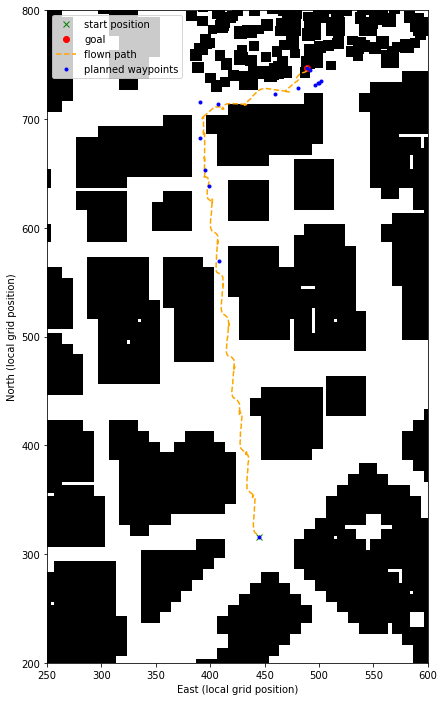

In [102]:
fig, ax = plt.subplots(1,1)
#ax.imshow(grid==0, cmap='gray')
ax.imshow(grid, origin='lower', cmap='Greys') 

_ = ax.plot(grid_start[E], grid_start[N], 'gx', label='start position')
_ = ax.plot(grid_goal[E], grid_goal[N], 'ro', label='goal')

_ = ax.plot(local_pos.east, local_pos.north, '--', c="orange", label="flown path")
pp = np.array(grid_path)
_ = ax.plot(pp[:,E], pp[:,N], '.', c='blue', label="planned waypoints")

#_ = ax.set_title("Actual and Planned Trajectory")
_ = ax.set_xlabel("East (local grid position)")
_ = ax.set_ylabel("North (local grid position)")
_ = ax.set_xlim([250, 600])
_ = ax.set_ylim([200, 800])
ax.legend(loc="best")

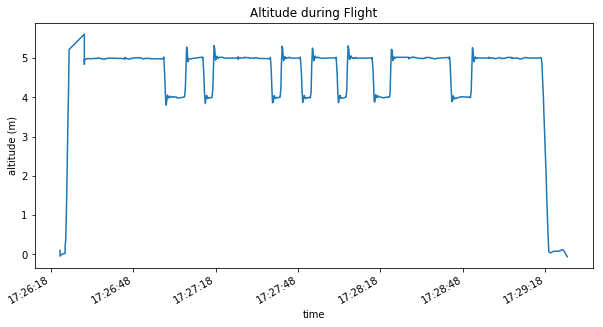

In [103]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
local_pos.set_index("t").z.plot(ax=ax)
_ = ax.set_title("Altitude during Flight")
_ = ax.set_xlabel("time")
_ = ax.set_ylabel("altitude (m)")